В этом задании нам предстоит проанализировать набор данных [Weather in Szeged 2006-2016](https://www.kaggle.com/budincsevity/szeged-weather), содержащий информацию о погоде. В качестве зависимой переменной возьмём температуру воздуха в градусах Цельсия (`Temperature (C)`).

Наша цель состоит в том, чтобы построить две линейные регрессионные модели: объясняющую и предиктивную. Объясняющая модель должна быть пригодна для статистической интерпретации зависимостей, то есть показывать, какие факторы влияют на температуру воздуха, каким образом и какое возможное объяснение этого влияния можно привести. Предиктивная модель может быть совершенно ужасной с точки зрения статистики (например, все коэффициенты могут быть не значимы), но она должна давать хорошие прогнозы в соответствии с некоторой метрикой.

Хотя приведённые данные имеют формат временных рядов, мы будем игнорировать это и рассматривать их как обычные кросс-секционные данные (то есть как независимые наблюдения в пространстве).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


Изучим статью о том, что такое [apparent temperature](https://www.kxan.com/weather/difference-between-temperature-and-feels-like-temperature/) (также называемая "feels-like temperature" и "heat index"). 

In [5]:
data = data.drop(['Formatted Date'], axis = 1)
data = data.drop(['Daily Summary'], axis = 1)

In [6]:
data = data.drop(['Humidity'], axis = 1)

Убираем колонку влажности, т.к. ее вклад в целевую переменную будет учитываться в параметре Apparent Temperature

In [7]:
data.head()

,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,Partly Cloudy,rain,9.472222,7.388889,14.1197,251.0,15.8263,0.0,1015.13
1,Partly Cloudy,rain,9.355556,7.227778,14.2646,259.0,15.8263,0.0,1015.63
2,Mostly Cloudy,rain,9.377778,9.377778,3.9284,204.0,14.9569,0.0,1015.94
3,Partly Cloudy,rain,8.288889,5.944444,14.1036,269.0,15.8263,0.0,1016.41
4,Mostly Cloudy,rain,8.755556,6.977778,11.0446,259.0,15.8263,0.0,1016.51


In [8]:
columns_num = ['Apparent Temperature (C)', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)',
       'Loud Cover', 'Pressure (millibars)']
columns_cat = ['Summary', 'Precip Type']
target = ['Temperature (C)']

In [9]:
data.isnull().sum()

Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
dtype: int64

In [10]:
data = data.dropna()

In [11]:
for col in columns_num:
    print(data[col].value_counts())

 12.777778    378
 17.777778    373
 13.888889    342
 17.222222    329
 12.222222    305
             ... 
 30.277778      1
 34.688889      1
 24.322222      1
-25.922222      1
 21.816667      1
Name: Apparent Temperature (C), Length: 8984, dtype: int64
3.2200     2441
11.2700    1493
6.4400     1356
0.0000     1297
8.0500      920
           ... 
43.9852       1
40.7974       1
41.7634       1
39.9924       1
31.2179       1
Name: Wind Speed (km/h), Length: 2484, dtype: int64
0.0      2262
150.0    1795
160.0    1630
140.0    1507
310.0    1450
         ... 
74.0       52
83.0       48
95.0       47
86.0       47
94.0       44
Name: Wind Bearing (degrees), Length: 360, dtype: int64
9.9820     18213
16.1000     7034
15.8263     5664
11.2700     4579
10.3523     3529
           ...  
11.7208        1
13.9265        1
15.5687        1
13.2342        1
13.0410        1
Name: Visibility (km), Length: 949, dtype: int64
0.0    95936
Name: Loud Cover, dtype: int64
0.00       1288
1017.70  

In [12]:
data = data.drop(['Loud Cover'], axis = 1)
columns_num.remove('Loud Cover')

 Удаляем столбец 'Loud Cover', т.к. в нем присутствует единственное значение, равное нулю 

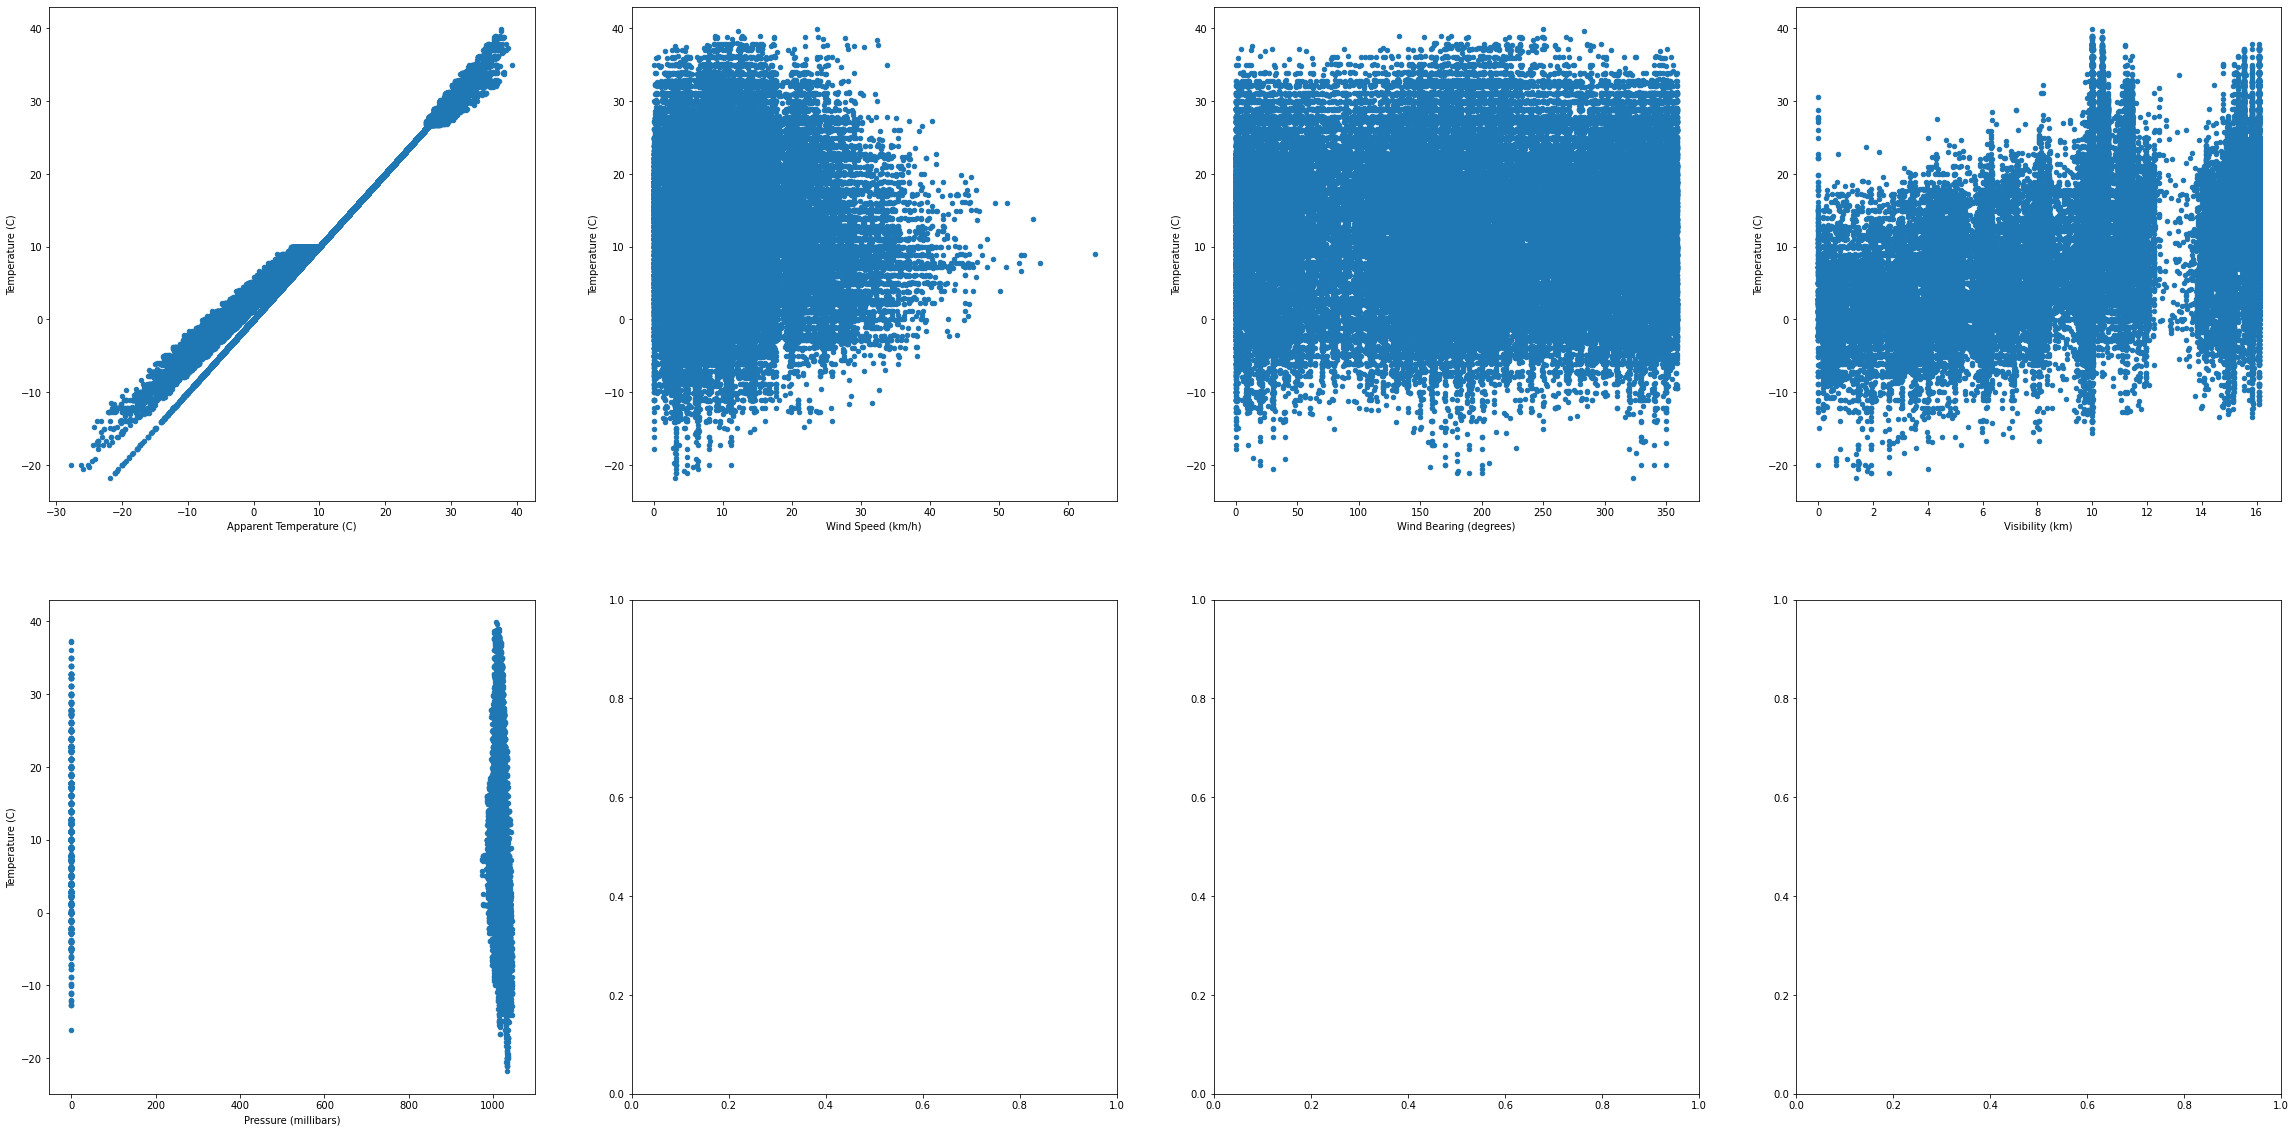

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))

for idx, feature in enumerate(columns_num):
    data.plot(feature, "Temperature (C)", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Очевидная линейная зависимость наблюдается для параметра Apparent Temperature

In [14]:
data = pd.get_dummies(data, columns=columns_cat)
columns_cat_new = []
for col_name in columns_cat:
    columns_cat_new.extend(filter(lambda x: x.startswith(col_name), data.columns))
columns_cat = columns_cat_new

In [15]:
data.corr()

,Temperature (C),Apparent Temperature (C),Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Pressure (millibars),Summary_Breezy,Summary_Breezy and Dry,Summary_Breezy and Foggy,Summary_Breezy and Mostly Cloudy,...,Summary_Partly Cloudy,Summary_Rain,Summary_Windy,Summary_Windy and Dry,Summary_Windy and Foggy,Summary_Windy and Mostly Cloudy,Summary_Windy and Overcast,Summary_Windy and Partly Cloudy,Precip Type_rain,Precip Type_snow
Temperature (C),1.000000,0.992637,0.008304,0.029937,0.393719,-0.005253,-0.009966,0.003093,-0.024854,-0.006512,...,0.300242,-0.001968,-0.004901,0.005155,-0.000044,-0.000212,-0.009072,-0.005450,0.563503,-0.563503
Apparent Temperature (C),0.992637,1.000000,-0.057387,0.028951,0.382589,-0.000037,-0.016551,0.003087,-0.032558,-0.014971,...,0.297419,-0.001196,-0.007544,0.004664,-0.000659,-0.001975,-0.014484,-0.010634,0.566058,-0.566058
Wind Speed (km/h),0.008304,-0.057387,1.000000,0.104366,0.100801,-0.049453,0.073173,0.010732,0.062587,0.239942,...,-0.070561,-0.007387,0.041382,0.013736,0.031139,0.089196,0.101960,0.129135,0.067771,-0.067771
Wind Bearing (degrees),0.029937,0.028951,0.104366,1.000000,0.048900,-0.011629,0.010055,0.001578,-0.004784,0.027475,...,0.016422,0.002309,0.011245,-0.001128,-0.001955,0.013149,0.011457,0.026489,0.042142,-0.042142
Visibility (km),0.393719,0.382589,0.100801,0.048900,1.000000,0.061011,-0.004465,-0.000294,-0.040006,0.019661,...,0.244970,-0.020997,0.000766,-0.000294,-0.013086,0.003649,-0.002886,0.007105,0.316483,-0.316483
Pressure (millibars),-0.005253,-0.000037,-0.049453,-0.011629,0.061011,1.000000,-0.088882,0.000508,0.000942,-0.001585,...,0.059333,0.001233,-0.068195,0.000469,0.000486,-0.003800,0.000609,-0.011239,-0.009271,0.009271
Summary_Breezy,-0.009966,-0.016551,0.073173,0.010055,-0.004465,-0.088882,1.000000,-0.000077,-0.000453,-0.001745,...,-0.016646,-0.000242,-0.000217,-0.000077,-0.000153,-0.000453,-0.000514,-0.000627,-0.008331,0.008331
Summary_Breezy and Dry,0.003093,0.003087,0.010732,0.001578,-0.000294,0.000508,-0.000077,1.000000,-0.000062,-0.000237,...,-0.002265,-0.000033,-0.000029,-0.000010,-0.000021,-0.000062,-0.000070,-0.000085,0.001145,-0.001145
Summary_Breezy and Foggy,-0.024854,-0.032558,0.062587,-0.004784,-0.040006,0.000942,-0.000453,-0.000062,1.000000,-0.001405,...,-0.013400,-0.000195,-0.000174,-0.000062,-0.000123,-0.000365,-0.000414,-0.000505,-0.040020,0.040020
Summary_Breezy and Mostly Cloudy,-0.006512,-0.014971,0.239942,0.027475,0.019661,-0.001585,-0.001745,-0.000237,-0.001405,1.000000,...,-0.051580,-0.000751,-0.000672,-0.000237,-0.000475,-0.001405,-0.001593,-0.001944,0.014306,-0.014306


Лучше всего коррелируют переменные Apparent Temperature, Precip Type_rain и Precip Type_snow

<AxesSubplot:>

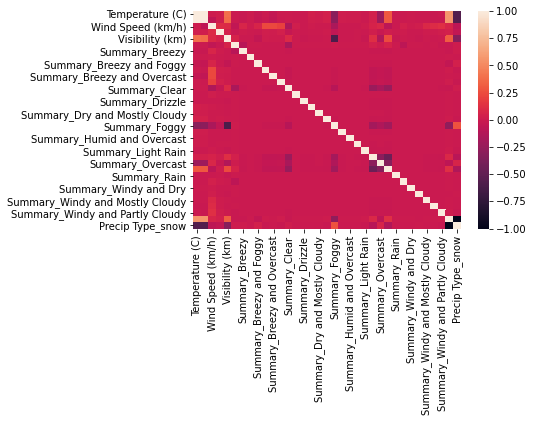

In [16]:
import seaborn as sns
sns.heatmap(data.corr())

In [29]:
X = data[columns_cat+columns_num]
y = data['Temperature (C)']

In [18]:
print(X.shape)
print(y.shape)

(95936, 34)
(95936,)


<AxesSubplot:>

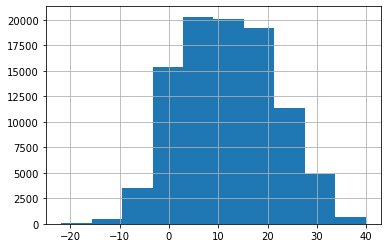

In [19]:
y.hist()

Распределение действительно похоже на нормальное.
Нам это важно в силу того, что мы используем оценку МSE. И то, что мы получили распределение, похожее на нормальное, подверждает правильность выбора оценки (MSE) и выбора модели для решения данной задачи. Корнем всего этого являются шумы точек, которые взяты из нормального распределения (по центральной предельной теореме) 

### Часть 2: Построение объясняющей модели 

1) Apparent Temperature (C) - очевидно, что ощущаемая температура связана с реальной температурой\
2) Apparent Temperature (C)^(2) - из формулы нахождения ощущаемой температуры видно, что ощущаемая и реальная температура\ завясят нелинейно. Поэтому есть смысл добавить признак ощущаемой температуры в квадрате\
3) Wind Speed (km/h) - с точки зрения логики, скорость ветра должна влиять на температуру\
4) Visibility (km) - аналогично\
5) Pressure (millibars) - аналогично\
6) Summary_Partly Cloudy - аналогично облачность напрямую влияет на температуру

In [44]:
X['Apparent Temperature (C)' + '_sq'] = X['Apparent Temperature (C)']**(2)

In [37]:
x1_col = ['Apparent Temperature (C)_sq', 'Apparent Temperature (C)', 'Wind Speed (km/h)', 'Visibility (km)', 'Pressure (millibars)', 'Summary_Partly Cloudy']
X1 = X[x1_col]

In [41]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X1, y)


print(lm.intercept_)
print(lm.coef_)

1.2917819873497933
[ 3.73512807e-03  8.05100698e-01  8.40730373e-02  3.36263064e-02
 -2.37696222e-04  4.72291732e-02]


In [42]:
list(zip(x1_col, lm.coef_))

[('Apparent Temperature (C)_sq', 0.003735128072743004),
 ('Apparent Temperature (C)', 0.8051006977017411),
 ('Wind Speed (km/h)', 0.08407303732753554),
 ('Visibility (km)', 0.03362630642564974),
 ('Pressure (millibars)', -0.00023769622209875063),
 ('Summary_Partly Cloudy', 0.04722917319821245)]

Самый значимый вклад в тагрет вносит параметр Apparent Temperature (C), что вполне ожидаемо по результатам таблицы корреляции.\
Также можно видеть, что параметр давления отрицательно влияет на таргет, но значение по модулю очень мало. Поэтому можно сказать, что это произошло случайно.

1) Apparent Temperature (C)_sq влияет на таргет положительно, однако не очень сильно (он как минимум на один порядок меньше остальных коэффициентов), поэтому можно сделать вывод, что мы сделали неправильное предположение на его счет.\
При увеличении Apparent Temperature (C)_sq на 100, реальная температура увеличится на 0.37 градуса.\
2) Apparent Temperature (C) влияет положительно, причем очень сильно, при увеличении на 10 градусов ощущаемой температуры, реаьная увеличится на 8.\
3) Коэффициенты признаков Wind Speed (km/h), Visibility (km), Summary_Partly Cloudy можно объединить, так они именют одинаковую степень важности (так как они одного порядка). При увеличении каждого на 100, таргет увеличится соответственно на 8.4, 3.4 и 4.7 соответственно.\
4) Признак Pressure влияет на таргет отрицательно, однако по модулю число мало. Из-за чего можно сказать, что это произошло случайно.





In [59]:
pred = lm.predict(X1)

Посчитаем $R^2$

In [60]:
from sklearn.metrics import r2_score
r2 = r2_score(y, pred)
print(r2)

0.9922013670054872


Посчитаем MSE

In [62]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y, pred)
print(mse)

0.7143296843903905


$R^2$ показывает нам, что модель действительно хорошая (результат близок к 1), а MSE это подтверждает. 

### Часть 3: Построение предсказательной модели 

В предыдущей части мы хотели объяснить $y$ при помощи каких-то регрессоров, которые мы отбирали из теоретико-логических соображений. Теперь поставим другую задачу: мы не хотим ничего объяснять, а хотим только хорошо предсказывать $y$ по новым наблюдениям. 

In [63]:
from sklearn.model_selection import train_test_split

np.random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [64]:
X_train_1 = X_train[x1_col]
X_test_1 = X_test[x1_col]

In [66]:
lm = LinearRegression()
lm.fit(X_train_1, y_train)


list(zip(x1_col, lm.coef_))

[('Apparent Temperature (C)_sq', 0.003754926463064915),
 ('Apparent Temperature (C)', 0.8048381901429251),
 ('Wind Speed (km/h)', 0.08380453443394409),
 ('Visibility (km)', 0.034154145363882046),
 ('Pressure (millibars)', -0.0002337789527966598),
 ('Summary_Partly Cloudy', 0.046294008185834665)]

In [68]:
pred_train = lm.predict(X_train_1)
pred_test = lm.predict(X_test_1)

In [69]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
print(mae_train)
print(mae_test)

0.6411750687611334
0.6403628911079368


Добавим еще прзнаков

In [70]:
dop_col = ['Precip Type_rain', 'Precip Type_snow', 'Summary_Overcast', 'Summary_Breezy and Foggy']

In [71]:
X_train_2 = X_train[x1_col + dop_col]
X_test_2 = X_test[x1_col + dop_col]

In [73]:
lm = LinearRegression()
lm.fit(X_train_2, y_train)


list(zip(x1_col+dop_col, lm.coef_))

[('Apparent Temperature (C)_sq', 0.005463308250629996),
 ('Apparent Temperature (C)', 0.7461451768756227),
 ('Wind Speed (km/h)', 0.07523925555545882),
 ('Visibility (km)', 0.031525609703826916),
 ('Pressure (millibars)', -0.00021699453592996474),
 ('Summary_Partly Cloudy', 0.06373528234899363),
 ('Precip Type_rain', 0.7013681208898113),
 ('Precip Type_snow', -0.7013681208898109),
 ('Summary_Overcast', 0.10786705426470151),
 ('Summary_Breezy and Foggy', 1.4755287310773872)]

In [74]:
pred_train = lm.predict(X_train_2)
pred_test = lm.predict(X_test_2)

In [75]:
from sklearn.metrics import mean_absolute_error
mae_train = mean_absolute_error(y_train, pred_train)
mae_test = mean_absolute_error(y_test, pred_test)
print(mae_train)
print(mae_test)

0.5908034904231675
0.5913176777772934


Качество повысить удалось на обеих выборках. Так как мы оцениеваем качество с помощью MAE, то чем меньше данный показатель, тем лучше качество. Что собственно и получилось.

В данной модели появились новые сильно значимае признаки, такие как Precip Type_rain, Precip Type_snow, Summary_Overcast, Summary_Breezy and Foggy.\
Любопытная ситуация возникла с признаками Precip Type_rain и Precip Type_snow. Они вносят примерно одинаковый вклад в таргет но разный по знаку. Так например увеличение признака Precip Type_rain на 10 приводит к увеличению таргета на 7. В ситуации с признаком Precip Type_swon всё строго наоборот. Увеличение на 10, приводит к уменьшению таргета на 7.\
Также абсолютно неожиданно самы большой коэффициент имеен признак Summary_Breezy and Foggy, при его увеличении на 10, таргет увеличится на 14.7. Что оказалось полной неожиданностью.

Модель, оценённую на X_train_1, можно брать для предскааний. Так как $R^2$ очень близок к 1, хотя показатель MSE по хорошему бы иметь поменьше.\
Модель, оценённую на X_train_2 вряд ли подойдет для объяснения. Так как например параметр Summary_Breezy and Foggy имеет наибольший вклад в таргет по результатам модели, хотя логически это трудно предугадать и по таблице корреляции видно, что данный признак слабо коррелирует с таргетом